# Natural Product Likeness Analysis

Sample molecules from COCONUT and ChEMBL35 datasets and compare their natural product likeness using perplexity.

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../.."))
smiles_gpt_path = os.path.abspath("../../externals/smiles-gpt")
sys.path.append(smiles_gpt_path)

In [2]:
MODEL_CHECKPOINT = "../../model/coconut_chiral_deepchem_tokenizer/model.ckpt"
TOKENIZER_NAME = "kohbanye/SmilesTokenizer_PubChem_1M"
USE_HF_TOKENIZER = True

DATASETS = [
    ("../../data/coconut_chiral.smi", "COCONUT"),
    ("../../data/chembl_35_chiral.smi", "ChEMBL35"),
]

N_SAMPLES_PER_DATASET = 10000
RANDOM_SEED = 42
BATCH_SIZE = 32

SIGMOID_K = 0.5  # Sigmoid slope for normalization
SIGMOID_CENTER = 5.0  # Sigmoid center point
MAX_PERPLEXITY_PLOT = 20  # Maximum perplexity for plots

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import random

from npgpt import SmilesGptModel, SmilesGptTrainingConfig, get_tokenizer

# Set style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

/home/5/uq02055/fs/git/npgpt/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model and Tokenizer

In [4]:
# Load model and tokenizer using configuration
config = SmilesGptTrainingConfig()
tokenizer = get_tokenizer(config, TOKENIZER_NAME, USE_HF_TOKENIZER)

model = SmilesGptModel.load_from_checkpoint(
    MODEL_CHECKPOINT,
    config=config,
    tokenizer=tokenizer,
    strict=False,
)

model.eval()
print("Model loaded successfully")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Model loaded successfully


## Perplexity Calculation Functions

In [5]:
def calculate_perplexity(model, tokenizer, smiles):
    try:
        tokens = tokenizer.encode(smiles, add_special_tokens=True)
        input_ids = torch.tensor([tokens])

        with torch.no_grad():
            outputs = model({"input_ids": input_ids, "labels": input_ids})
            loss = outputs.loss

        perplexity = torch.exp(loss).item()
        return perplexity
    except Exception as e:
        print(f"Error processing SMILES '{smiles}': {e}")
        return None


def evaluate_dataset(model, tokenizer, smiles_list, batch_size=None):
    if batch_size is None:
        batch_size = BATCH_SIZE
        
    results = []
    errors = 0

    for i in tqdm(range(0, len(smiles_list), batch_size)):
        batch = smiles_list[i : i + batch_size]

        for smiles in batch:
            ppl = calculate_perplexity(model, tokenizer, smiles)
            if ppl is not None:
                results.append({"smiles": smiles, "perplexity": ppl})
            else:
                errors += 1

    print(f"Successfully evaluated: {len(results)}, Errors: {errors}")
    return pd.DataFrame(results)

## Dataset Sampling

In [6]:
def load_and_sample(filepath, n_samples=None, seed=None):
    if n_samples is None:
        n_samples = N_SAMPLES_PER_DATASET
    if seed is None:
        seed = RANDOM_SEED
        
    with open(filepath, "r") as f:
        all_smiles = []
        for line in f:
            if line.strip():
                # Handle both formats: "SMILES" and "SMILES\tID"
                parts = line.strip().split("\t")
                smiles = parts[0]
                all_smiles.append(smiles)

    random.seed(seed)
    n_samples = min(n_samples, len(all_smiles))
    sampled = random.sample(all_smiles, n_samples)

    print(f"Loaded {len(all_smiles)} molecules, sampled {n_samples}")
    return sampled


dataset_samples = {}
for filepath, dataset_name in DATASETS:
    print(f"\nLoading {dataset_name}...")
    samples = load_and_sample(filepath)
    dataset_samples[dataset_name] = samples

print(f"\nLoaded {len(DATASETS)} datasets successfully")


Loading COCONUT...
Loaded 895557 molecules, sampled 10000

Loading ChEMBL35...
Loaded 2474590 molecules, sampled 10000

Loaded 2 datasets successfully


## Perplexity Evaluation

In [7]:
all_results = []

for dataset_name, samples in dataset_samples.items():
    print(f"Evaluating {dataset_name} samples...")
    results = evaluate_dataset(model, tokenizer, samples)
    results["dataset"] = dataset_name
    all_results.append(results)

all_results = pd.concat(all_results, ignore_index=True)
print(f"\nTotal evaluated: {len(all_results)} molecules across {len(DATASETS)} datasets")

Evaluating COCONUT samples...


100%|██████████| 313/313 [02:20<00:00,  2.22it/s]


Successfully evaluated: 10000, Errors: 0
Evaluating ChEMBL35 samples...


  1%|▏         | 4/313 [00:01<01:38,  3.13it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (665 > 514). Running this sequence through the model will result in indexing errors


Error processing SMILES 'C(=O)(COCCOCCNC(=O)CCCCCCCCCCCCCCCCC(=O)O)NCCCCCCNC(=O)C1NC(=O)CCN2C(=O)C(CC2=O)SC[C@@H](C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@H](C(=O)N2[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)NCC(=O)N[C@H](C(=O)N3[C@H](C(=O)N4CCC[C@H]4C(=O)N4CCC[C@H]4C(=O)N[C@@H](CO)C(=O)N)CCC3)C)CO)CO)CCC2)CCCCN)[C@H](CC)C)CC(C)C)Cc2c3ccccc3[nH]c2)CCC(=O)O)[C@@H](C)CC)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CSC2CC(=O)N(C2=O)CCC(=O)NCCCC1)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H]([C@H](O)C)NC(=O)[C@H](C(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)N)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@@H](NC(=O)CNC(=O)[C@@H](NC(=O)C(C)(NC(=O)[C@H](Cc1c[nH]cn1)N)C)CCC(=O)O)[C@@H](C)O)CC(=O)O)Cc1ccc(O)cc1)CCC(=O)O)C': index out of range in self
Error processing SMILES 'N([C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O

  7%|▋         | 21/313 [00:07<01:34,  3.09it/s]

Error processing SMILES '[Na+].c1(ccc(cc1)C(O)P(=O)([O-])O)OP(=S)(N(/N=C/c1ccc(cc1)OP1(=NP(=NP(=N1)(Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(P(=O)([O-])O)O)Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)C(O)P(=O)([O-])O)(Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)C(O)P(=O)([O-])O)Oc1ccc(cc1)/C=N/N(C)P(=S)(Oc1ccc(cc1)C(O)P(=O)(O)[O-])Oc1ccc(cc1)C(O)P(=O)([O-])O)C)Oc1ccc(cc1)C(O)P(=O)(O)[O-].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+]': index out of range in self


 55%|█████▍    | 172/313 [01:01<00:48,  2.90it/s]

Error processing SMILES 'n1(c(=O)[nH]c(=O)c(c1)C)[C@H]1C[C@H](O)[C@H](O1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)nc(c(c2)C)N)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)nc(c(c2)C)N)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)nc(c(c2)C)N)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@H](C1)c1cn(nn1)c1ccc(cc1)C)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)nc(c(c2)C)N)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O[C@@H]1[C@H](O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)COP(=O)(O)O[C@@H]1[C@@H](COP(=O)(O[C@@H]2[C@H](O[C@@H](n3c(=O)[nH]c(=O)c(c3)C)C2)CO)O)O[C@@H](n2c(=O)[nH]c(=O)c(c2)C)C1)O)O)O)O)O)O)O)O)O)O)O)O': index out of range in self


 75%|███████▌  | 236/313 [01:24<00:25,  3.07it/s]

Error processing SMILES 'C(=O)(N1[C@H](C(=O)N[C@H](C(=O)O)CCCCNC(=O)CCCCCCCCCCCCC)CCC1)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@H]1NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](Cc2ccccc2)N)C(C)C)CC(=O)N)CCC(=O)N)Cc2nc[nH]c2)CC(C)C)CSSC[C@@H]2NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CN)[C@H](CC)C)C(C)C)CCC(=O)O)CCC(=O)N)CSSC[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC2=O)[C@H](O)C)CO)[C@H](CC)C)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CC(=O)N)C(=O)O)CSSC1)Cc1ccc(cc1)O)CC(=O)N)CCC(=O)O)CC(C)C)CCC(=O)N)Cc1ccc(cc1)O)CC(C)C)CO)CO)Cc1nc[nH]c1)CC(C)C)C(C)C)CCC(=O)O)C)CC(C)C)Cc1ccc(cc1)O)CC(C)C)C(C)C)CCC(=O)O)CCCNC(=N)N)Cc1ccccc1)Cc1ccccc1)Cc1ccc(cc1)O

 81%|████████  | 253/313 [01:30<00:19,  3.08it/s]

Error processing SMILES 'O=C(NC(C)(C)C(=O)N[C@@H](CCC(=O)O)C(=O)NCC(=O)N[C@@H]([C@H](O)C)C(=O)N[C@@H](Cc1ccc(cc1)O)C(=O)N[C@@H]([C@H](O)C)C(=O)N[C@@H](CC(=O)N)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CS)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccc(cc1)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CS)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H](CCCCN)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CO)C(=O)NCC(=O)N[C@@H](C)C(=O)N1[C@@H](CCC1)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N)[C@H](Cc1c[nH]cn1)N': index out of range in self


100%|██████████| 313/313 [01:51<00:00,  2.80it/s]

Successfully evaluated: 9994, Errors: 6

Total evaluated: 19994 molecules across 2 datasets


## Statistical Analysis

In [8]:
print("=== Perplexity Statistics ===")
print(all_results.groupby("dataset")["perplexity"].describe())

if len(DATASETS) == 2:
    from scipy import stats

    dataset_names = [name for _, name in DATASETS]
    dataset1_ppl = all_results[all_results["dataset"] == dataset_names[0]]["perplexity"].values
    dataset2_ppl = all_results[all_results["dataset"] == dataset_names[1]]["perplexity"].values

    # Mann-Whitney U test (non-parametric)
    statistic, p_value = stats.mannwhitneyu(dataset1_ppl, dataset2_ppl, alternative="less")
    print(f"\nMann-Whitney U test ({dataset_names[0]} vs {dataset_names[1]}):")
    print(f"  Statistic: {statistic}")
    print(f"  p-value: {p_value:.2e}")
    print(f"  {dataset_names[0]} has {'significantly' if p_value < 0.001 else 'not significantly'} lower perplexity than {dataset_names[1]}")
else:
    print(f"\nSkipping pairwise statistical test (requires exactly 2 datasets, got {len(DATASETS)})")

=== Perplexity Statistics ===
            count      mean        std       min       25%       50%  \
dataset                                                                
COCONUT   10000.0  1.446053   0.319285  1.054210  1.266975  1.364297   
ChEMBL35   9994.0  8.612860  10.650530  1.494437  4.792236  6.805559   

               75%         max  
dataset                         
COCONUT   1.517491    6.670969  
ChEMBL35  9.979093  681.337585  

Mann-Whitney U test (COCONUT vs ChEMBL35):
  Statistic: 98479.0
  p-value: 0.00e+00
  COCONUT has significantly lower perplexity than ChEMBL35


## Visualization

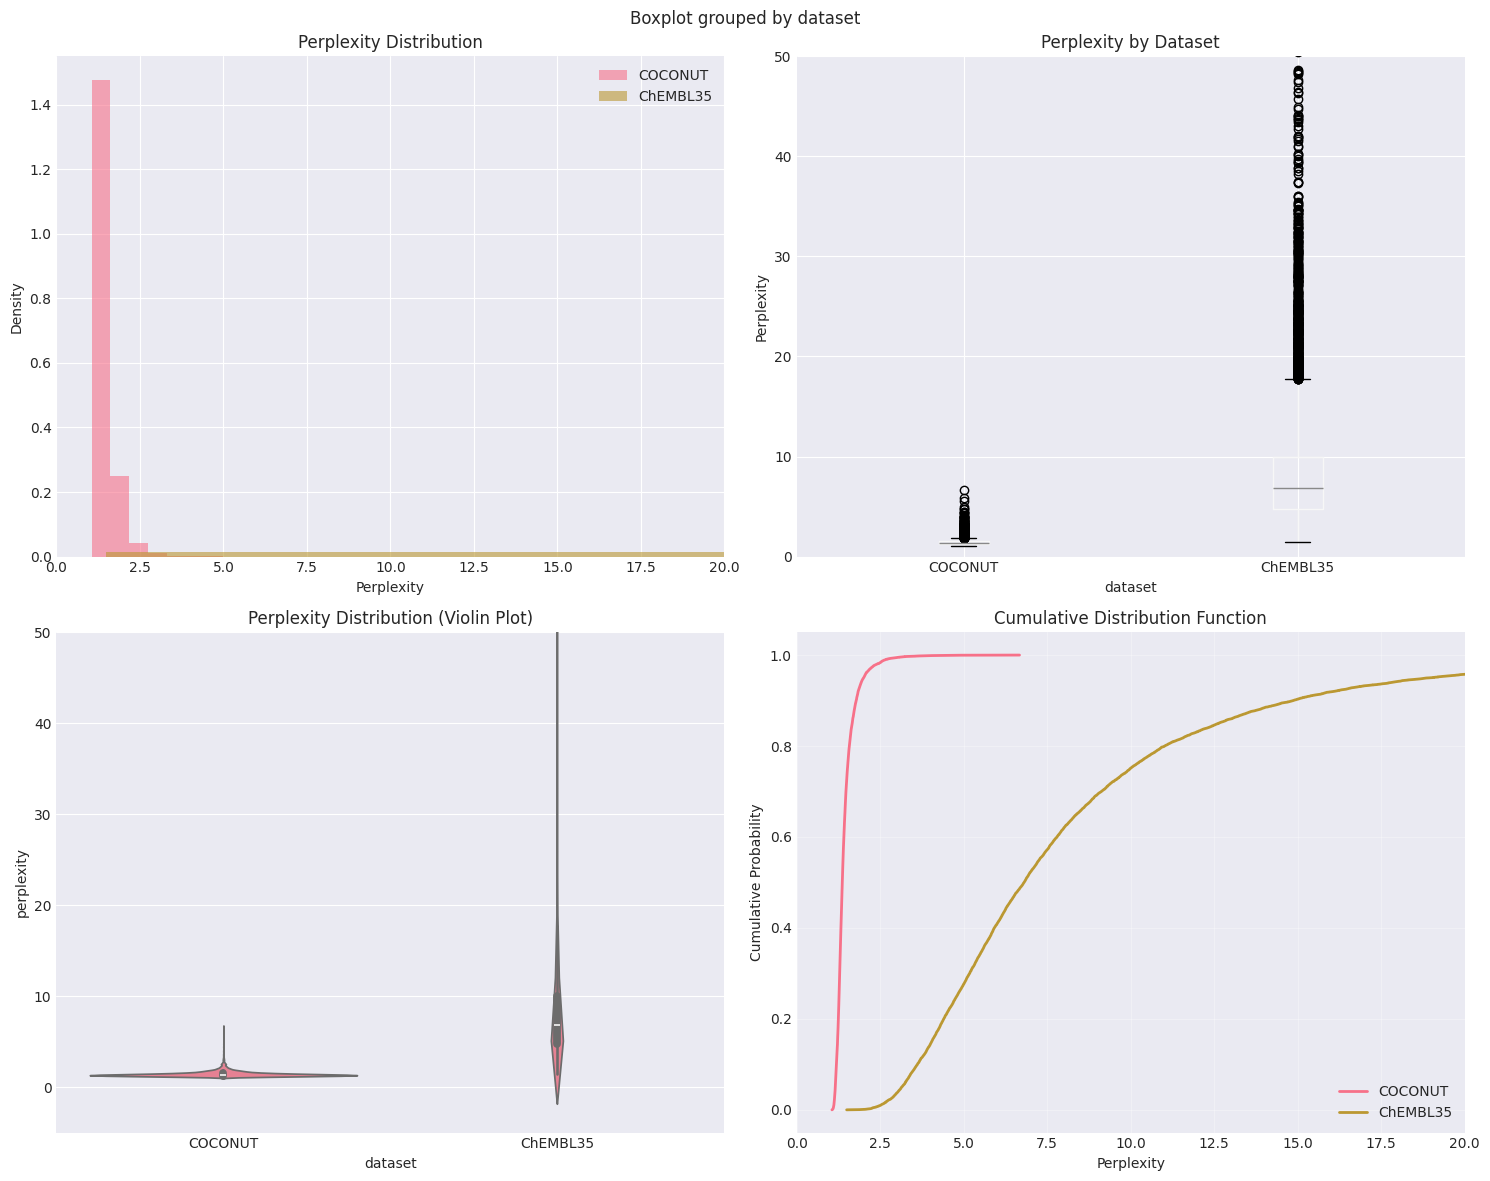

In [9]:
# Create visualizations using configuration
dataset_names = [name for _, name in DATASETS]
n_datasets = len(DATASETS)

if n_datasets == 2:
    # Two-dataset comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    ax = axes[0, 0]
    for dataset in dataset_names:
        data = all_results[all_results["dataset"] == dataset]["perplexity"]
        ax.hist(data, alpha=0.6, label=dataset, density=True)
    ax.set_xlabel("Perplexity")
    ax.set_ylabel("Density")
    ax.set_title("Perplexity Distribution")
    ax.legend()
    ax.set_xlim(0, MAX_PERPLEXITY_PLOT)

    ax = axes[0, 1]
    all_results.boxplot(column="perplexity", by="dataset", ax=ax)
    ax.set_title("Perplexity by Dataset")
    ax.set_ylabel("Perplexity")
    ax.set_ylim(0, MAX_PERPLEXITY_PLOT * 2.5)

    ax = axes[1, 0]
    sns.violinplot(data=all_results, x="dataset", y="perplexity", ax=ax)
    ax.set_title("Perplexity Distribution (Violin Plot)")
    ax.set_ylim(-5, MAX_PERPLEXITY_PLOT * 2.5)

    ax = axes[1, 1]
    for dataset in dataset_names:
        data = all_results[all_results["dataset"] == dataset]["perplexity"].sort_values()
        ax.plot(data, np.linspace(0, 1, len(data)), label=dataset, linewidth=2)
    ax.set_xlabel("Perplexity")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Cumulative Distribution Function")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, MAX_PERPLEXITY_PLOT)

else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    ax = axes[0, 0]
    for dataset in dataset_names:
        data = all_results[all_results["dataset"] == dataset]["perplexity"]
        ax.hist(data, alpha=0.6, label=dataset, density=True)
    ax.set_xlabel("Perplexity")
    ax.set_ylabel("Density")
    ax.set_title("Perplexity Distribution")
    ax.legend()
    ax.set_xlim(0, MAX_PERPLEXITY_PLOT)
    
    ax = axes[0, 1]
    sns.boxplot(data=all_results, x="dataset", y="perplexity", ax=ax)
    ax.set_title("Perplexity by Dataset")
    ax.set_ylabel("Perplexity")
    ax.set_ylim(0, MAX_PERPLEXITY_PLOT * 2)
    ax.tick_params(axis='x', rotation=45)
    
    ax = axes[1, 0]
    sns.violinplot(data=all_results, x="dataset", y="perplexity", ax=ax)
    ax.set_title("Perplexity Distribution (Violin Plot)")
    ax.set_ylim(0, MAX_PERPLEXITY_PLOT * 2)
    ax.tick_params(axis='x', rotation=45)
    
    ax = axes[1, 1]
    means = all_results.groupby("dataset")["perplexity"].mean()
    stds = all_results.groupby("dataset")["perplexity"].std()
    ax.bar(means.index, means.values, yerr=stds.values, capsize=5, alpha=0.7)
    ax.set_ylabel("Mean Perplexity")
    ax.set_title("Average Perplexity by Dataset")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Perplexity Score Normalization (0-1 Range)

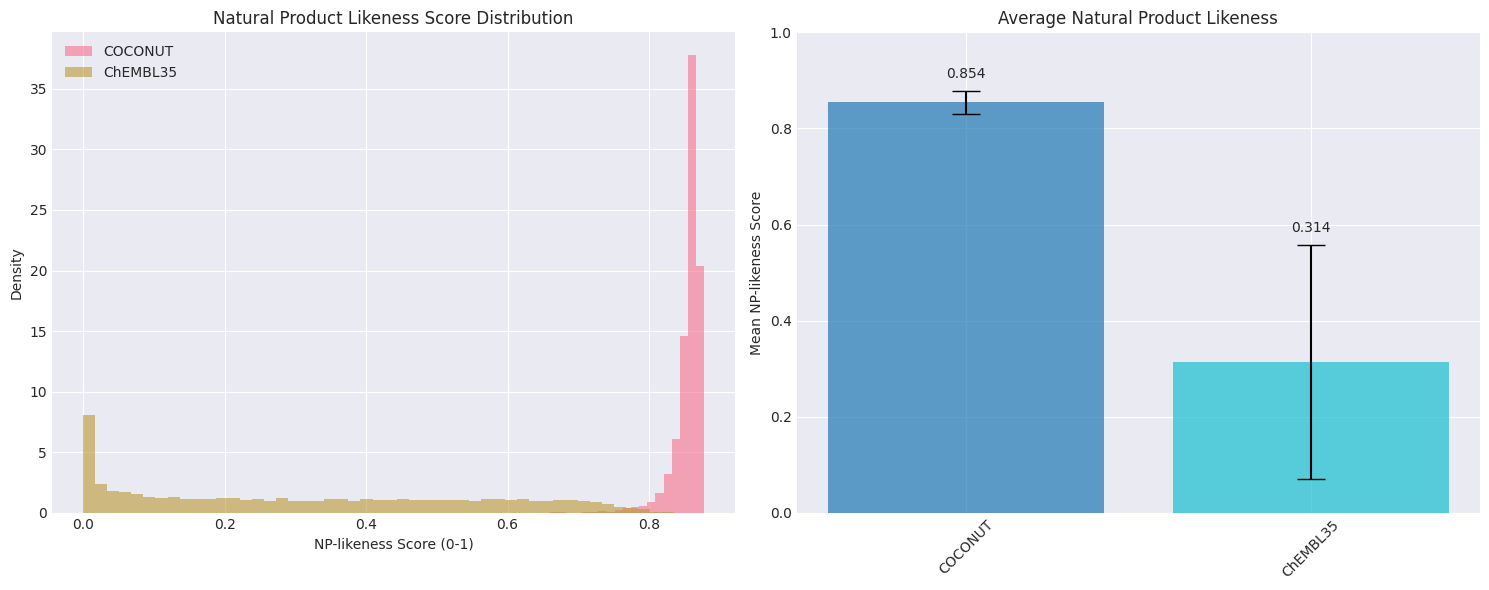


=== NP-likeness Score Summary ===
            count      mean       std            min       25%       50%  \
dataset                                                                    
COCONUT   10000.0  0.854184  0.024344   3.024867e-01  0.850846  0.860308   
ChEMBL35   9994.0  0.314031  0.243535  1.365084e-147  0.076594  0.288480   

               75%       max  
dataset                       
COCONUT   0.866054  0.877922  
ChEMBL35  0.525947  0.852303  


In [10]:
def sigmoid_transform(perplexity, k=None, center=None):
    """Sigmoid transformation to 0-1 range"""
    if k is None:
        k = SIGMOID_K
    if center is None:
        center = SIGMOID_CENTER
    return 1 / (1 + np.exp(k * (perplexity - center)))


# Apply normalization
all_results["np_score"] = all_results["perplexity"].apply(sigmoid_transform)

# Visualize normalized scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Normalized score distribution
for dataset in dataset_names:
    data = all_results[all_results["dataset"] == dataset]["np_score"]
    ax1.hist(data, bins=50, alpha=0.6, label=dataset, density=True)
ax1.set_xlabel("NP-likeness Score (0-1)")
ax1.set_ylabel("Density")
ax1.set_title("Natural Product Likeness Score Distribution")
ax1.legend()

# Mean scores with error bars
mean_scores = all_results.groupby("dataset")["np_score"].agg(["mean", "std"])
colors = plt.cm.tab10(np.linspace(0, 1, len(dataset_names)))
bars = ax2.bar(
    mean_scores.index,
    mean_scores["mean"],
    yerr=mean_scores["std"],
    capsize=10,
    alpha=0.7,
    color=colors,
)
ax2.set_ylabel("Mean NP-likeness Score")
ax2.set_title("Average Natural Product Likeness")
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for i, (idx, row) in enumerate(mean_scores.iterrows()):
    ax2.text(
        i,
        row["mean"] + row["std"] + 0.02,
        f"{row['mean']:.3f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

# Print summary
print("\n=== NP-likeness Score Summary ===")
print(all_results.groupby("dataset")["np_score"].describe())

## Representative Molecule Examples

In [11]:
for dataset_name in dataset_names:
    dataset_results = all_results[all_results["dataset"] == dataset_name]
    
    print(f"\n=== {dataset_name} Examples ===")
    print(f"Most Natural Product-like (Lowest Perplexity):")
    top = dataset_results.nsmallest(3, "perplexity")
    for _, row in top.iterrows():
        print(f"  {row['smiles'][:60]}... | Perplexity: {row['perplexity']:.2f}")
    
    print(f"Least Natural Product-like (Highest Perplexity):")
    bottom = dataset_results.nlargest(3, "perplexity")
    for _, row in bottom.iterrows():
        print(f"  {row['smiles'][:60]}... | Perplexity: {row['perplexity']:.2f}")


=== COCONUT Examples ===
Most Natural Product-like (Lowest Perplexity):
  CCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO[C@H]1[C@@H]([C@H]([C@@H]([C... | Perplexity: 1.05
  CCCCCCCCCCCCCCC[C@H]([C@H](CO[C@H]1[C@@H]([C@H]([C@@H]([C@@H... | Perplexity: 1.06
  O=C(O)C1(OC(CO)C(O)C2OC(OC3C(O)C(OC(CO)C3OC3OC(CO)C(O)C(OC4O... | Perplexity: 1.06
Least Natural Product-like (Highest Perplexity):
  ICC(O)CO... | Perplexity: 6.67
  Ic1ccncc1N... | Perplexity: 5.88
  [O-][I+](O)(O)(O)(O)O... | Perplexity: 5.52

=== ChEMBL35 Examples ===
Most Natural Product-like (Lowest Perplexity):
  Cc1cccc2c1nc1COC[C@H](CNC3CCCCC3)n21... | Perplexity: 1.49
  CC(C)C[C@@H](C(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCCN)N... | Perplexity: 1.53
  O=C(N)C(NN=C(c1ccccc1)c1ccccc1)c1ccccc1... | Perplexity: 1.74
Least Natural Product-like (Highest Perplexity):
  Cl.N1(CCNCCCNCCNCCC1)Cc1ccc(CN2CCNCCCNCCNCCC2)cc1.[Zn+2].[Zn... | Perplexity: 681.34
  Cc1nc(COC[C@@H]2CC[C@H]3NCC[C@H]3O2)cs1.Cl.Cl... | Perplexity: 458.19
  [C-]#[O+]... | 